In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Direktori data
base_dir = "datasets/tomato"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Parameter
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Build model
def build_model(trainable=False):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,), pooling='avg')
    base_model.trainable = trainable

    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3 if not trainable else 1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_efficientnet_tomato.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [3]:

# Fase 1: Train top classifier
print("🚀 Training fase 1...")
model = build_model(trainable=False)
history1 = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[early_stopping, checkpoint])

# Fase 2: Fine-tuning
print("\n🔧 Fine-tuning EfficientNet...")
model = build_model(trainable=True)
for layer in model.layers[1].layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stopping, checkpoint])


🚀 Training fase 1...


Epoch 1/25


313/313 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.7227
Epoch 1: val_accuracy improved from -inf to 0.86300, saving model to best_efficientnet_tomato.keras
313/313 [==============================] - 547s 2s/step - loss: 0.8403 - accuracy: 0.7227 - val_loss: 0.4202 - val_accuracy: 0.8630
Epoch 2/25
313/313 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8585
Epoch 2: val_accuracy improved from 0.86300 to 0.87700, saving model to best_efficientnet_tomato.keras
313/313 [==============================] - 289s 922ms/step - loss: 0.4248 - accuracy: 0.8585 - val_loss: 0.3806 - val_accuracy: 0.8770
Epoch 3/25
313/313 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8826
Epoch 3: val_accuracy improved from 0.87700 to 0.90500, saving model to best_efficientnet_tomato.keras
313/313 [==============================] - 278s 887ms/step - loss: 0.3371 - accuracy: 0.8826 - val_loss: 0.2846 - 

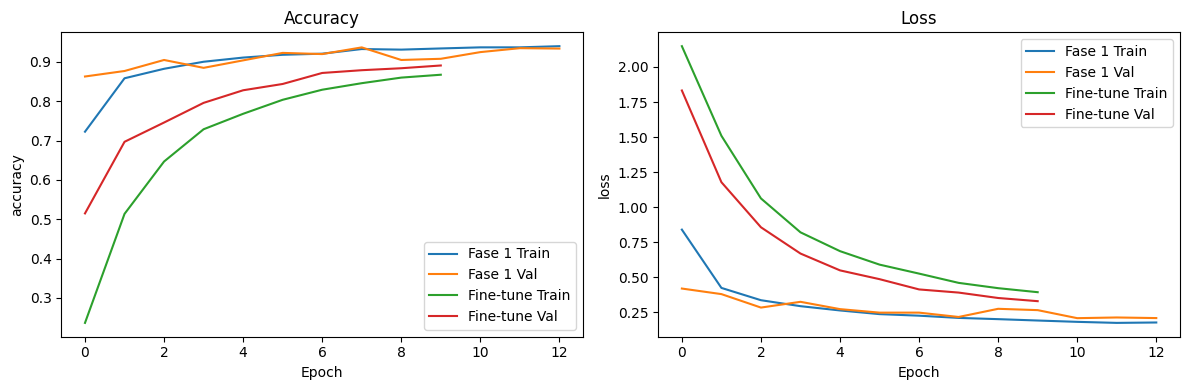


📊 Evaluasi model terbaik (best checkpoint)...
32/32 [==============================] - 86s 906ms/step

📄 Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial spot       0.97      0.89      0.93       100
                        Early blight       0.94      0.93      0.93       100
                         Late blight       0.94      0.95      0.95       100
                           Leaf Mold       0.96      0.96      0.96       100
                  Septoria leaf spot       0.95      0.93      0.94       100
Spider mites Two spotted spider mite       0.91      0.86      0.89       100
                         Target Spot       0.81      0.92      0.86       100
       Tomato Yellow Leaf Curl Virus       0.98      0.95      0.96       100
                 Tomato mosaic virus       0.95      0.99      0.97       100
                             healthy       0.97      0.99      0.98       100

           

<Figure size 1000x1000 with 0 Axes>

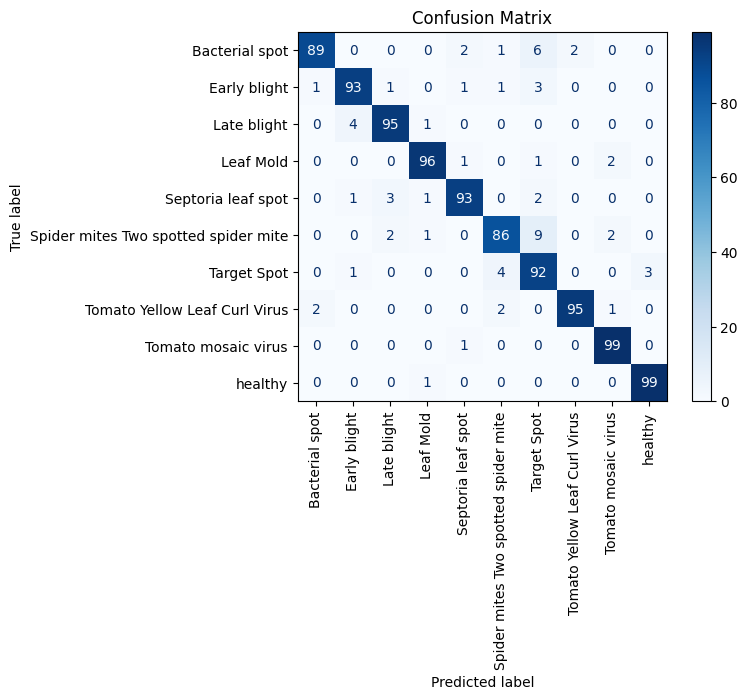

In [6]:

# 📊 Visualisasi Training History
def plot_history(histories, labels):
    plt.figure(figsize=(12, 4))
    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i+1)
        for hist, label in zip(histories, labels):
            plt.plot(hist.history[metric], label=f'{label} Train')
            plt.plot(hist.history[f'val_{metric}'], label=f'{label} Val')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history1, history2], ['Fase 1', 'Fine-tune'])

# 🔍 Evaluasi: Confusion Matrix & Report
print("\n📊 Evaluasi model terbaik (best checkpoint)...")
model = tf.keras.models.load_model('best_efficientnet_tomato.keras')

# Prediksi
val_gen.reset()
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

class_labels_clean = [label.replace("Tomato___", "").replace("_", " ") for label in class_labels]

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels_clean))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_clean)
plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()



📊 Evaluasi model terbaik (best checkpoint)...
32/32 [==============================] - 106s 788ms/step

📄 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.89      0.93       100
                        Tomato___Early_blight       0.94      0.93      0.93       100
                         Tomato___Late_blight       0.94      0.95      0.95       100
                           Tomato___Leaf_Mold       0.96      0.96      0.96       100
                  Tomato___Septoria_leaf_spot       0.95      0.93      0.94       100
Tomato___Spider_mites_Two_spotted_spider_mite       0.91      0.86      0.89       100
                         Tomato___Target_Spot       0.81      0.92      0.86       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.95      0.96       100
                 Tomato___Tomato_mosaic_virus       0.95      0.99      0.97       100

<Figure size 1000x1000 with 0 Axes>

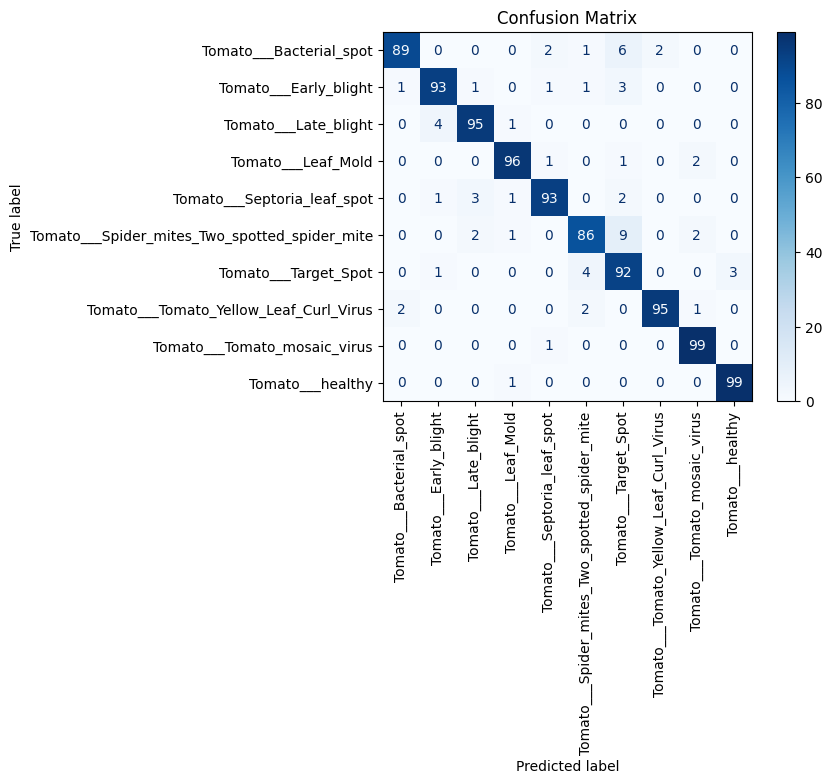

In [5]:
print("\n📊 Evaluasi model terbaik (best checkpoint)...")
model = tf.keras.models.load_model('best_efficientnet_tomato.keras')

# Prediksi
val_gen.reset()
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()